In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pylab as plt
import numpy as np
import cv2

In [2]:
#a) Load the oxford_iiit_pet dataset

# Construct a tf.data.Dataset
train_ds, test_ds = tfds.load('oxford_iiit_pet', split=['train','test[:40%]'], shuffle_files=False)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteX28H2L/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteX28H2L/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.
<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


In [21]:
def read_and_preprocess(data):
  input_image = tf.image.resize(data['image'], (128, 128), method=tf.image.ResizeMethod.AREA)
  input_mask = tf.image.resize(data['segmentation_mask'], (128, 128), method=tf.image.ResizeMethod.AREA)

  input_image = tf.image.convert_image_dtype(input_image, tf.float32) / 255 # normalizing image
  input_mask -= 1 # {1,2,3} to {0,1,2}
  print(input_mask)

  return input_image, input_mask

In [5]:
train = train_ds.map(read_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test = test_ds.map(read_and_preprocess)

Tensor("sub:0", shape=(128, 128, 1), dtype=float32)
Tensor("sub:0", shape=(128, 128, 1), dtype=float32)


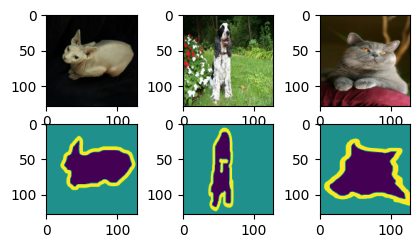

In [9]:
# b) Create the segmentation mask
# Show some images from dataset and their segmented version

plt.figure(figsize=(5, 4))
plt_index = 0
for image in train.take(3):
  ax = plt.subplot(3, 3, plt_index + 1)
  plt.xticks()
  plt.yticks()
  plt.imshow(image[0])
  plt_index = plt_index + 1


for image in train.take(3):
  ax = plt.subplot(3, 3, plt_index + 1)
  plt.xticks()
  plt.yticks()
  plt.imshow(image[1])
  plt_index = plt_index + 1

**Part 2- Annotation**

In [2]:
# Install mrcnn
!pip install mrcnn -q

# Get data from here https://github.com/experiencor/raccoon_dataset
# Clone to cloud repo
!git clone https://github.com/experiencor/raccoon_dataset.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 kB 657.6 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [74]:
# Reading in local images using CV
data_dir = pathlib.Path(data_dir)
ds_images = []
for sub_dir in data_dir.glob('*/'):
    if sub_dir.is_dir():
      dir_name = sub_dir.name
      # Iterate over image files in the subdirectory
      for image_path in sub_dir.glob('*.jpg'):
          # Append the image path to the list
        ds_images.append(image_path)
print(len(ds_images))
print(ds_images[0])

200
/content/raccoon_dataset/images/raccoon-127.jpg


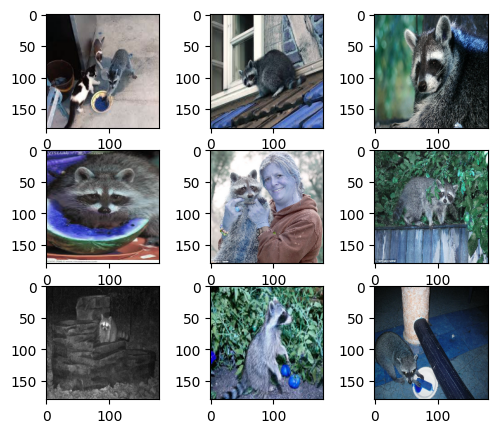

In [73]:
plt.figure(figsize=(6, 5))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  # loading image
  image = cv2.imread(str(ds_images[i]))
  # Resizing image
  resized = cv2.resize(image, (180, 180))
  plt.imshow(resized)
  plt.axis("on")

plt.show()

In [27]:
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from mrcnn.utils import Dataset

# class that defines and loads the raccoon dataset
class RaccoonDataset(Dataset):
	# load the dataset definitions
	def load_dataset(self, dataset_dir, is_train=True):
		# define one class
		self.add_class("raccoon_dataset", 1, "raccoon")
		# define data locations
		images_dir = dataset_dir + '/images/'
		annotations_dir = dataset_dir + '/annotations/raccoon-'
		# find all images
		for filename in listdir(images_dir):
			# extract image id
			image_id = filename[8:-4]
			# skip bad images
			if image_id in ['00090']:
				continue
			# skip all images after 150 if we are building the train set
			if is_train and int(image_id) >= 150:
				continue
			# skip all images before 150 if we are building the test/val set
			if not is_train and int(image_id) < 150:
				continue
			img_path = images_dir + filename
			ann_path = annotations_dir + image_id + '.xml'
			# add to dataset
			self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)

	# extract bounding boxes from an annotation file
	def extract_boxes(self, filename):
		# load and parse the file
		tree = ElementTree.parse(filename)
		# get the root of the document
		root = tree.getroot()
		# extract each bounding box
		boxes = list()
		for box in root.findall('.//bndbox'):
			xmin = int(box.find('xmin').text)
			ymin = int(box.find('ymin').text)
			xmax = int(box.find('xmax').text)
			ymax = int(box.find('ymax').text)
			coors = [xmin, ymin, xmax, ymax]
			boxes.append(coors)
		# extract image dimensions
		width = int(root.find('.//size/width').text)
		height = int(root.find('.//size/height').text)
		return boxes, width, height

	# load the masks for an image
	def load_mask(self, image_id):
		# get details of image
		info = self.image_info[image_id]
		# define box file location
		path = info['annotation']
		# load XML
		#path = '/content/raccoon_dataset/annotations/raccoon-'+image_id   #Added by me
		boxes, w, h = self.extract_boxes(path)
		# create one array for all masks, each on a different channel
		masks = zeros([h, w, len(boxes)], dtype='uint8')
		# create masks
		class_ids = list()
		for i in range(len(boxes)):
			box = boxes[i]
			row_s, row_e = box[1], box[3]
			col_s, col_e = box[0], box[2]
			masks[row_s:row_e, col_s:col_e, i] = 1
			class_ids.append(self.class_names.index('raccoon'))
		return masks, asarray(class_ids, dtype='int32')

	# load an image reference
	def image_reference(self, image_id):
		info = self.image_info[image_id]
		return info['path']

# train set
train_set = RaccoonDataset()
train_set.load_dataset('raccoon_dataset', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))

# test/val set
test_set = RaccoonDataset()
test_set.load_dataset('raccoon_dataset', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

Train: 149
Test: 51


<class '__main__.RaccoonDataset'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


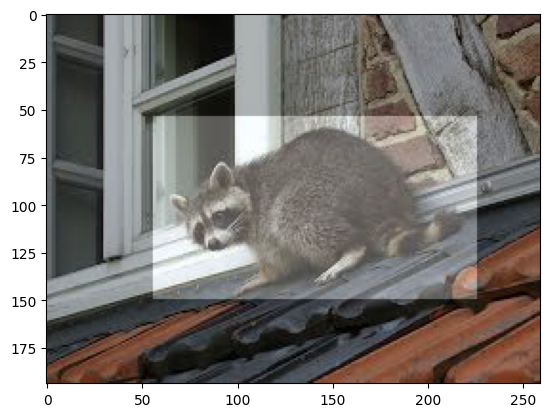

In [77]:
# load an image
# Use the function above to create the image and its mask

image_id = 1  # Change this to load a different image
print(type(train_set))
image = train_set.load_image(image_id)
print(type(image))
mask, class_ids = train_set.load_mask(image_id)
print(type(mask), type(class_ids))

# Display the image
plt.imshow(image)

# Display the mask
for i in range(mask.shape[2]):
    plt.imshow(mask[:, :, i], cmap='gray', alpha=0.3, vmin=0, vmax=1)
plt.show()

**Part 3- YOLO 8**




In [ ]:
# a- Create annotation
# You can upload the file using ![title](filename.jpeg)
# import image module



In [ ]:
#b- Now, we want to install Yolo8.
# Download required tools
# Clone yolo 8 and check all dependencies


Cloning into 'yolov5'...
remote: Enumerating objects: 12618, done.
remote: Total 12618 (delta 0), reused 0 (delta 0), pack-reused 12618
Receiving objects: 100% (12618/12618), 12.45 MiB | 16.79 MiB/s, done.
Resolving deltas: 100% (8651/8651), done.
/content/yolov5
     |████████████████████████████████| 596 kB 33.7 MB/s 


In [ ]:
#c- Train the model here
# Follow the Github instruction to train a YOLO8 model here

In [ ]:
#d- Test model
#Import ultralytics
# Test this above trained model on an image. For example: https://ultralytics.com/images/bus.jpg


In [ ]:
# e- See the result.
# Show the result and all the assigned objects here

In [ ]:
# What is your understanding from this image? What is the meaning of these numbers all over the image?